In [38]:
import catboost
import xgboost
import lightgbm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier     
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from asid.automl_imbalanced.abb import AutoBalanceBoost

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from hyperopt import hp, fmin, tpe

from model.reduce_model import ReduceModel, AE, VAE

In [30]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [60]:
reduce_model = ReduceModel(AE((1145, 286, 72, 18, 5)))

In [61]:
reduce_model.train(100)

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]

Epoch 100, Train Loss: 1.1248148227825242e-05
Epoch 100, Validation Loss: 1.126015567106978e-05


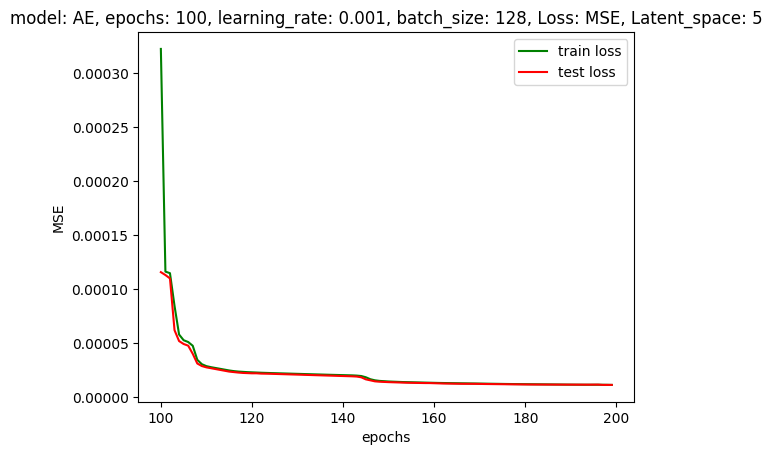

In [62]:
reduce_model.plot_loss()

In [65]:
main_reduced = reduce_model.transform(dataset)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

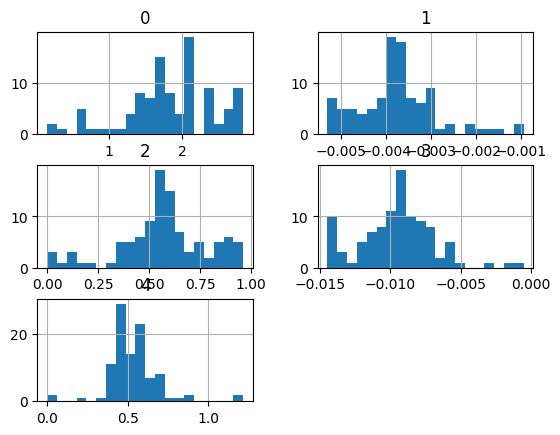

In [66]:
pd.DataFrame(main_reduced).hist(bins=20)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [68]:
X_train

array([[ 1.63596618e+00, -3.57766263e-03,  5.24247825e-01,
        -8.40056408e-03,  4.83483553e-01],
       [ 1.05886734e+00, -3.35743953e-03,  5.44839025e-01,
        -5.51696029e-03,  4.68084902e-01],
       [ 2.10522795e+00, -5.22633176e-03,  9.34367955e-01,
        -1.02537153e-02,  5.80723107e-01],
       [ 2.05008769e+00, -3.58442683e-03,  5.25756299e-01,
        -1.02825183e-02,  4.39964205e-01],
       [ 2.34402680e+00, -4.98263771e-03,  8.81597102e-01,
        -1.11037884e-02,  4.51214582e-01],
       [ 1.52303442e-01, -9.39352729e-04, -4.14189533e-04,
        -5.23320865e-04, -2.76935403e-04],
       [ 2.40318847e+00, -5.24651911e-03,  9.44489837e-01,
        -1.18502509e-02,  6.28753245e-01],
       [ 1.34832466e+00, -3.21716652e-03,  4.56304491e-01,
        -7.45077850e-03,  5.82565248e-01],
       [ 2.76480079e+00, -3.86270205e-03,  5.49243033e-01,
        -1.44586992e-02,  6.96776509e-01],
       [ 2.84083366e+00, -4.61285934e-03,  7.85526574e-01,
        -1.40013350e-02

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

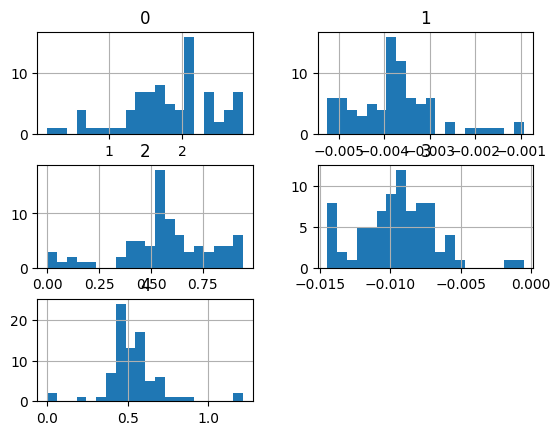

In [69]:
pd.DataFrame(X_train).hist(bins=20)

In [73]:
clf = catboost.CatBoostClassifier()
clf.fit(X_train, y_train)
print(metrics.classification_report(y_test, clf.predict(X_test)))

Learning rate set to 0.003523
0:	learn: 0.6911187	total: 162ms	remaining: 2m 41s
1:	learn: 0.6896770	total: 163ms	remaining: 1m 21s
2:	learn: 0.6883131	total: 165ms	remaining: 54.8s
3:	learn: 0.6866527	total: 166ms	remaining: 41.4s
4:	learn: 0.6849261	total: 168ms	remaining: 33.4s
5:	learn: 0.6835027	total: 169ms	remaining: 28.1s
6:	learn: 0.6820049	total: 172ms	remaining: 24.3s
7:	learn: 0.6808916	total: 173ms	remaining: 21.5s
8:	learn: 0.6793679	total: 175ms	remaining: 19.3s
9:	learn: 0.6773887	total: 177ms	remaining: 17.5s
10:	learn: 0.6761641	total: 178ms	remaining: 16s
11:	learn: 0.6746755	total: 180ms	remaining: 14.8s
12:	learn: 0.6734121	total: 181ms	remaining: 13.8s
13:	learn: 0.6723279	total: 183ms	remaining: 12.9s
14:	learn: 0.6705672	total: 184ms	remaining: 12.1s
15:	learn: 0.6693067	total: 186ms	remaining: 11.5s
16:	learn: 0.6682436	total: 188ms	remaining: 10.9s
17:	learn: 0.6666820	total: 190ms	remaining: 10.4s
18:	learn: 0.6646603	total: 192ms	remaining: 9.9s
19:	learn: 0